In [29]:
import re
from unidecode import unidecode

import csv
from openai import OpenAI
import pandas as pd
from os import path
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
OPENAI_API_KEY = 'your-openai-api-key'

client = OpenAI(
    api_key=OPENAI_API_KEY,
)

# Methodology

This notebook implements an automated classification system for occupational data from workplace accidents using Large Language Models (LLMs). The methodology follows these key steps:

**1. Data Preprocessing**: Raw occupation titles from the ACHS (Chilean Work Safety Association) accident database are normalized by removing accents, standardizing punctuation, and converting to lowercase to ensure consistent classification.

**2. LLM-Based Classification**: We employ OpenAI's GPT-4o model to classify occupations according to the International Labour Organization (ILO) occupational classification system. The classification process uses a structured prompting approach:
- (a) system instructions define the task and classification rules, explicitly stating to avoid managerial classifications unless explicitly mentione
- (b) the complete ILO taxonomy is provided as context in semicolon-separated format
- (c) each occupation title is processed individually with the query "What is the classification of the occupation {occupation}?" The model returns only the numeric classification code, ensuring consistent formatting for downstream analysis.

**3. Targeted Analysis**: We perform specialized classifications for two key occupational categories:
   - **Care Duties**: Healthcare, education, childcare, and domestic services (codes 221-235, 361, 531-532, 911-912)
   - **Manual and Machinery-Based Occupations**: Construction, manufacturing, transportation, and agricultural work (codes 72, 81, 83, 92, 93)

**4. Cross-Analysis**: The classified occupations are merged with accident mechanism data to analyze injury patterns by occupation type and sex, providing insights into workplace safety risks across different job categories.

In [1]:
DATA_ROOT_PATH = '../data'

# Data Normalization and Transformation
## Getting Unique Normalized Occupations from Accidents Data


In [41]:
new_achs_accidents_data = path.join(DATA_ROOT_PATH, 'masked','new_achs_accidents_data.csv')

In [42]:
new_achs_accidents_data = pd.read_csv(new_achs_accidents_data)
new_occupations = new_achs_accidents_data['ocupacion'].str.lower().unique()

new_occupations.shape

(44375,)

### Normalization Util

In [43]:
def normalize(s):
    if not isinstance(s, str):
        return s

    # Lowercase and remove accents (including ñ → n, ü → u)
    s = unidecode(s.lower())

    # Replace punctuation and normalize whitespace
    s = re.sub(r'[.,]', '', s)        # Remove dots and commas
    s = re.sub(r'[-]', ' ', s)        # Replace hyphens with space
    s = re.sub(r'\s+', ' ', s)        # Normalize multiple spaces

    return s.strip()


assert normalize("ÁÉÍÓÚÜÑ") == "aeiouun"
assert normalize("HE-LLO") == "he llo"
assert normalize("   HéLLo   ") == "hello"

## Normalize Dataframe

In [44]:
new_occupations_df = pd.DataFrame(new_occupations, columns=['ocupacion'])
new_occupations_df['ocupacion'] = new_occupations_df['ocupacion'].apply(normalize)
new_occupations_df['ocupacion'] = new_occupations_df['ocupacion'].str.strip()
new_occupations_df = new_occupations_df.drop_duplicates()

print(f"{'='*10}NORMALIZED OCCUPATIONS{'='*10}\n")
print("Number of unique occupations: ", new_occupations_df.shape[0])
print(new_occupations_df.head())

==========NORMALIZED OCCUPATIONS==========

Number of unique occupations:  42845
    ocupacion
0    operario
1  supervisor
2  mantencion
3    mecanico
4      cajera


In [ ]:
new_achs_accidents_data['ocupacion'] = new_achs_accidents_data['ocupacion'].str.lower()
new_achs_accidents_data['ocupacion'] = new_achs_accidents_data['ocupacion'].apply(normalize)
new_achs_accidents_data['ocupacion'] = new_achs_accidents_data['ocupacion'].str.strip()

print(new_achs_accidents_data['ocupacion'])

# Categorization

In [46]:
def run_llm(occupation, system_instructions, taxonomies=None):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": f"{system_instructions}"},
            {"role": "system", "content": f"{taxonomies}"},
            {"role": "user", "content": f"What is the classification of the occupation {occupation}?"}
        ]
    )
    return response.choices[0].message.content

def write_result(index, occupation, response, file_path):
    with open(file_path, 'a', encoding='utf-8') as f:
        f.write(f'{index},{occupation},{response}\n')

In [47]:
system_instructions = """
    You will receive some occupation
    titles from the user. Your task is to classify them according
    to the International Labour Organization occupational
    classification system. For instance, Professor, Teacher, and
    Preschool Teacher should be categorized under the same class.
    Do not assign occupations into managerial classes unless the
    occupation title explicitly states so, like ’Company manager’.
    Your answer should consist of only the number of the class; for
    example, the occupation ’doctor’ should be answered with only '22'.
"""

In [48]:
principal_subgroups_file_path = path.join(DATA_ROOT_PATH, 'classification', 'principal_subgroups.csv')
principal_subgroups = pd.read_csv(principal_subgroups_file_path, sep=';')

print(principal_subgroups.head())
print(principal_subgroups.shape)
print(principal_subgroups.dtypes)

   code                                        description
0    11  Miembros del Poder Ejecutivo y Legislativo, pe...
1    12  Directores y gerentes administrativos y de ser...
2    13  Directores, gerentes y administradores de prod...
3    14  Directores, gerentes y administradores de hote...
4    21   Profesionales de las ciencias y de la ingeniería
(41, 2)
code            int64
description    object
dtype: object


In [49]:
def build_categorization_prompt(subgroups_dataframe):
    content = "code;description\n"
    for index, row in subgroups_dataframe.iterrows():
        content += f"{row['code']};{row['description']}\n"
    return content

In [50]:
categorization_prompt = build_categorization_prompt(principal_subgroups)

print(categorization_prompt)

code;description
11;Miembros del Poder Ejecutivo y Legislativo, personal directivo de la administración pública y de otras organizaciones sociales y/o políticas, directores ejecutivos y gerentes generales
12;Directores y gerentes administrativos y de servicios comerciales
13;Directores, gerentes y administradores de producción y operaciones
14;Directores, gerentes y administradores de hoteles, restaurantes, comercios y de otros servicios
21;Profesionales de las ciencias y de la ingeniería
22;Profesionales de la salud
23;Profesionales de la educación
24;Profesionales de negocios y administración
25;Profesionales de tecnología de la información y las comunicaciones
26;Profesionales en derecho, ciencias sociales y culturales
31;Técnicos de las ciencias y la ingeniería
32;Técnicos de la salud
33;Técnicos en operaciones financieras y administrativas
34;Técnicos de servicios jurídicos, sociales, deportivos y culturales
35;Técnicos de la tecnología de la información y las comunicaciones
36;Té

In [65]:
input_occupation = 'aux de aseo'

output_occupation_code = int(run_llm(input_occupation, system_instructions, categorization_prompt))
output_occupation_description = principal_subgroups.loc[principal_subgroups['code'] == output_occupation_code, 'description'].values[0]

print("Input occupation: ", input_occupation)
print("Output:", output_occupation_code, "-", output_occupation_description)

Input occupation:  aux de aseo
Output: 91 - Auxiliares de aseo y trabajadores de casa particular


In [53]:
llm_classification_file_path = path.join(DATA_ROOT_PATH, 'outputs', 'llm_classification.csv')

In [51]:
def run_classification(output_path, dataframe, system_instructions, categorization_prompt, start_index=0):
    for index, occupation in enumerate(dataframe['ocupacion'][start_index:]):
        output_occupation_code = int(run_llm(occupation, system_instructions, categorization_prompt))
        write_result(index, occupation, output_occupation_code, output_path)

    print(f"Finished processing {len(dataframe)} occupations")

In [ ]:
run_classification(llm_classification_file_path, new_occupations_df, system_instructions, categorization_prompt, start_index=0)

In [58]:
classified_occupations = pd.read_csv(
    llm_classification_file_path,
    names=['index', 'ocupacion', 'clasificacion-oit'],
    on_bad_lines='skip',
    header=0
)

print(classified_occupations.head())
print(classified_occupations.shape)
print(classified_occupations.dtypes)

  index   ocupacion clasificacion-oit
0     0    operario                93
1     1  supervisor                12
2     2  mantencion                93
3     3    mecanico                72
4     4      cajera                42
(42738, 3)
index                object
ocupacion            object
clasificacion-oit    object
dtype: object


In [59]:
merged_occupations = pd.merge(
    new_achs_accidents_data,
    classified_occupations,
    on='ocupacion',
    how='inner'
)

print(merged_occupations.head())
print(merged_occupations.shape)
print(merged_occupations.dtypes)

   id_siniestro  tipo_siniestro  numero_paciente  \
0       7242104               2       1007054764   
1       7242107               2       1007001523   
2       7242197               1       1007055069   
3       7242333               1       1003302110   
4       7243063               1       1003972578   

                                               texto      poblacion  \
0  \nSTP\nCONTINUO INDICACION DE MANEJO AMBULATOR...        CHONCHI   
1  LEY \nREPOSO\nTRASLADO A CEM PARA INSTALAR CAN...      QUILICURA   
2  \n03.01.2022 10:37 RX PIE AP-OBL\n03.01.2022 1...  ISLA DE MAIPO   
3                                            ingreso     TALCAHUANO   
4  \nPARACETAMOL 500 MG (A), ORAL, 500 MG, C/8 HR...   PUERTO MONTT   

    ocupacion  edad       sexo  \
0    operario  22.0  masculino   
1  supervisor  29.0  masculino   
2  mantencion  46.0  masculino   
3    mecanico  42.0  masculino   
4      cajera  49.0   femenino   

                                     relato_admision  m

In [60]:
classification_codes = ['11', '12', '13', '14',
                        '21', '22', '23', '24', '25', '26',
                        '31', '32', '33', '34', '35', '36',
                        '41', '42', '43', '44',
                        '51', '52', '53', '54',
                        '61', '62', '63', 
                        '71', '72', '73', '75',
                        '81', '82', '83', 
                        '91', '92', '93', '94', '95', '96']

In [61]:
not_classified_occupations = merged_occupations[(merged_occupations['clasificacion-oit'] == '00') | (~merged_occupations['clasificacion-oit'].isin(classification_codes))]

print(not_classified_occupations.shape)

(698, 14)


In [78]:
not_classified_occupations[['ocupacion', 'clasificacion-oit']].drop_duplicates().to_csv('not_classified_occupations.csv', index=False)
print(not_classified_occupations['clasificacion-oit'].head)

<bound method NDFrame.head of 523       no puedo clasificar la ocupación "no se lo sab...
1292                                                     74
1936      no puedo clasificar "programa especial empleo"...
2927      no corresponde a una clasificación específica ...
5537      no puedo determinar la clasificación porque "m...
                                ...                        
339975                                                   00
340127                                                   00
340164                                                   00
340249                                                   00
340263                                                   00
Name: clasificacion-oit, Length: 698, dtype: object>


In [62]:
merged_occupations = merged_occupations[(merged_occupations['clasificacion-oit'].isin(classification_codes))]
print(merged_occupations.shape)

(340066, 14)


We now can get the Unique Classifications in the Merged Occupations

In [63]:
distinct_classifications = merged_occupations['clasificacion-oit'].nunique()
print(distinct_classifications)

40


## Zoom on Occupations Classified as Mining, Construction, Manufacturing and Transport Workers

In [64]:
# First we will Count how many occupations are classified in 93
mining_construction_manufacturing_transport_code = '93'

classified_occupations_93 = classified_occupations[classified_occupations['clasificacion-oit'] == mining_construction_manufacturing_transport_code]

print(classified_occupations_93.shape)

(708, 3)


In [65]:
classified_occupations_93['ocupacion'].unique()

array(['operario', 'mantencion', 'operario de produccion',
       'ayudante soldado r', 'operarios', 'pioneta', 'operario de bodega',
       'oepraria', 'operaria', 'ayud trefilado', 'asistente de obra',
       'ayudante albañil', 'pintor', 'ayudante avanzado producc',
       'ayudante de taller', 'descarga', 'operaria de produccion',
       'operario produccion', 'ayudante de carga', 'ayudante soldador',
       'ayudante de produccion', 'ayudante en obras', 'filetera',
       'peoneta', 'ayudante de electrico', 'logistica pesaje camiones',
       'ayudante de planta', 'capataz', 'cargador', 'operario huincha',
       'operario logistico', 'ayudante electromecanico', 'packing',
       'asistente de reparto', 'operador terreno', 'ayudante de operador',
       'tractorista', 'descargador de camion', 'ayudante de maquina',
       'ayud soldador', 'maestro terminaciones', 'recibidor de huincha',
       'trabajador', 'colocador de royos', 'rigger', 'maestro minero',
       'operario junior'

In [66]:
instruction_93_classifications = """
You will receive some occupation
titles from the user and a table for the International Labour
Organization (ILO) occupational classification system. Your task
is to classify the occupations into one of the ILO’s classes.
For instance, Operator, Production Operator, and Operations
Assistant should be under the same class. It is important that
you reply only with the class number. Provide the most probable
class; for example, for ’dam cleaning’, answer with ’933’.
"""

In [67]:
categorization_93_prompt = """
code;description
931;Obreros de la minería y la construcción
932;Empacadores manuales y obreros de la industria manufacturera
933;Obreros del transporte y almacenamiento
"""

In [96]:
occupation = 'ayudante avanzado producc'

occupation_code = run_llm(occupation, instruction_93_classifications, categorization_93_prompt)
print(occupation_code)

932


In [68]:
class_93_output_path = path.join(DATA_ROOT_PATH, 'outputs', 'llm_classification_93.csv')

In [ ]:
run_classification(class_93_output_path, classified_occupations_93, instruction_93_classifications, categorization_93_prompt)

In [69]:
classified_occupations_93 = pd.read_csv(class_93_output_path, names=['index', 'ocupacion', 'clasificacion-oit'], on_bad_lines='skip', dtype={'index': int, 'ocupacion': str, 'clasificacion-oit': str})


In [70]:
classified_occupations_93

,index,ocupacion,clasificacion-oit
0,0,operario,932
1,1,mantencion,931
2,2,operario de produccion,932
3,3,ayudante soldado r,931
4,4,operarios,932
...,...,...,...
703,703,limpieza diques,933
704,704,operario de terreno y tal,931
705,705,descargador pioneta,933
706,706,ornero,931


## Care Duties Analysis

Care Duties categories where analyzed manually with a final count of five categories. 

- 22 Health professionals
- 23 Education professionals
- 36 Education technicians
- 53 Personal care workers
- 91 Cleaning assistants and domestic workers

In [82]:
care_duties_codes = ['22', '23', '36', '53', '91']
care_duties_subcodes = [
    '221', '222', '223', '231', '232',
    '224', '234', '235', '361', '531',
    '532', '911', '912', '000',
]

We filter all the occupations by two conditions
`class ∈ care_duty`

In [74]:
care_occupations = merged_occupations[
    (merged_occupations['clasificacion-oit'].isin(care_duties_codes))
]['ocupacion'].unique()

print(len(care_occupations))

6908


In [75]:
CARE_DUTIES_SUBGROUPS_CSV_PATH = path.join(DATA_ROOT_PATH, 'classification', 'care_duties_subgroups.csv')

In [76]:
care_duties_subgroups_with_description = pd.read_csv(CARE_DUTIES_SUBGROUPS_CSV_PATH, sep=';')

In [77]:
instruction_care_duties_classifications = """
You will receive some occupation titles from the user and a table for the International Labour
Organization (ILO) occupational classification system. Your task is to classify the occupations
into one of the ILO's classes. It is important that you reply only with the class number.
Provide the most probable class. If the occupation does not fit any of the provided
classifications, answer with '000'.
"""

In [78]:
classification_care_duties_prompt = build_categorization_prompt(care_duties_subgroups_with_description)

print(classification_care_duties_prompt)

code;description
221;Médicos generales y especialistas
222;Profesionales de enfermería y matronería
223;Veterinarios
224;Dentistas, farmacéuticos, kinesiólogos, nutricionistas, fonoaudiólogos y otros profesionales de la salud
231;Profesores de la educación superior
232;Profesores de educación media técnico profesional (especialidades) y de formación laboral
234;Profesores de educación básica y educadores de párvulos
235;Especialistas en métodos pedagógicos, educadores para necesidades especiales y otros profesionales de la educación
361;Técnicos en educación
531;Cuidadores de niños, asistentes de aula e inspectores de patio
532;Trabajadores de los cuidados personales en instituciones y a domicilio
911;Trabajadores de casa particular, limpiadores de oficinas, hoteles y otros establecimientos
912;Limpiadores de ropa, vehículos, ventanas y otros limpiadores manuales
0;Ocupación no clasificable



In [79]:
care_duties_output_path = path.join(DATA_ROOT_PATH, 'outputs', 'llm_classification_care_duties.csv')

In [ ]:
run_classification(
    care_duties_output_path,
    care_occupations,
    instruction_care_duties_classifications,
    classification_care_duties_prompt
)

In [85]:
classified_care_duties = pd.read_csv(
    care_duties_output_path, 
    names=['index', 'ocupacion', 'clasificacion-oit'],
    on_bad_lines='skip',
    dtype={'index': int, 'ocupacion': str, 'clasificacion-oit': str}
)

print(classified_care_duties.head())
print(classified_care_duties.shape)
print(classified_care_duties.dtypes)

   index                ocupacion clasificacion-oit
0      0              aux de aseo               911
1      1         auxiliar de aseo               911
2      2              kinesiologa               224
3      3  educadora trato directo               235
4      4          auxiiar de aseo               911
(4397, 3)
index                 int64
ocupacion            object
clasificacion-oit    object
dtype: object


In [ ]:
merged_care_duties = pd.merge(
    new_achs_accidents_data,
    classified_care_duties,
    on='ocupacion',
    how='inner'
)

# We trim the classified with 000 and non 3-digit codes
merged_care_duties = merged_care_duties[merged_care_duties['clasificacion-oit'] != 0]
merged_care_duties = merged_care_duties[merged_care_duties['clasificacion-oit'].isin(care_duties_subcodes)]

print(merged_care_duties.head())

   id_siniestro  tipo_siniestro  numero_paciente  \
0       7246825               1       1001236538   
1       7252561               2       1007061785   
2       7252843               1       1007062205   
3       7261280               1       1007068429   
4       7265217               1       1007070918   

                                               texto   poblacion  \
0  BEG CLOTE OBESIDAD CENTRAL \n\nINGRESA EN SILL...    PUDAHUEL   
1                      REGULARIZACION  DE TRANSPORTE  SAN FELIPE   
2  \nALTA MEDICA\nCICLOBENZAPRINA 10 MG UN COMP. ...       AISEN   
3        ME GOLPEARON UN  MARTILLAZO EN EL ANTEBRAZO     QUILPUE   
4                                 control con imagen  LAS CONDES   

                 ocupacion  edad      sexo  \
0              aux de aseo  56.0  femenino   
1         auxiliar de aseo  48.0  femenino   
2              kinesiologa  28.0  femenino   
3  educadora trato directo  33.0  femenino   
4          auxiiar de aseo  60.0  femenino   

 

In [89]:
# Group by care duties and sex
classification_counts = merged_care_duties.groupby(
    ['clasificacion-oit', 'sexo']
).size().reset_index(name='count')

print(classification_counts)

   clasificacion-oit       sexo  count
0                000   femenino   3481
1                000  masculino   1971
2                221   femenino    600
3                221  masculino    389
4                222   femenino    660
5                222  masculino    389
6                223   femenino     87
7                223  masculino     32
8                224   femenino   1837
9                224  masculino    493
10               231   femenino    152
11               232   femenino    236
12               232  masculino     16
13               234   femenino    983
14               235   femenino   1717
15               235  masculino     24
16               361   femenino   7391
17               361  masculino    483
18               531   femenino   2747
19               531  masculino    585
20               532   femenino    904
21               532  masculino    436
22               911   femenino  14461
23               911  masculino   2819
24               912   fe

In [90]:
TRANSLATED_CARE_DUTIES_SUBGROUPS_PATH = path.join(
    DATA_ROOT_PATH, 'classification', 'translated_care_duties_subgroups.csv'
)

classification_codes_description = pd.read_csv(
    TRANSLATED_CARE_DUTIES_SUBGROUPS_PATH,
    sep=';',
    names=['code', 'description'],
    on_bad_lines='skip',
    dtype={'code': str, 'description': str}
)

# Standarization for formats
classification_counts['clasificacion-oit'] = classification_counts['clasificacion-oit'].astype(str)

print(classification_codes_description.head())

   code                          description
0  code                          description
1   221       General and Specialist Doctors
2   222  Nursing and Midwifery Professionals
3   223                        Veterinarians
4   231            Higher Education Teachers


In [95]:
care_duties = pd.merge(
    classification_counts,
    classification_codes_description,
    left_on='clasificacion-oit',
    right_on='code',
    how='left'
)

print(care_duties.head())

care_duties_df = pd.DataFrame(care_duties, columns=['clasificacion-oit', 'sexo', 'count', 'description'])

  clasificacion-oit       sexo  count code  \
0               000   femenino   3481  000   
1               000  masculino   1971  000   
2               221   femenino    600  221   
3               221  masculino    389  221   
4               222   femenino    660  222   

                           description  
0            Unclassifiable Occupation  
1            Unclassifiable Occupation  
2       General and Specialist Doctors  
3       General and Specialist Doctors  
4  Nursing and Midwifery Professionals  


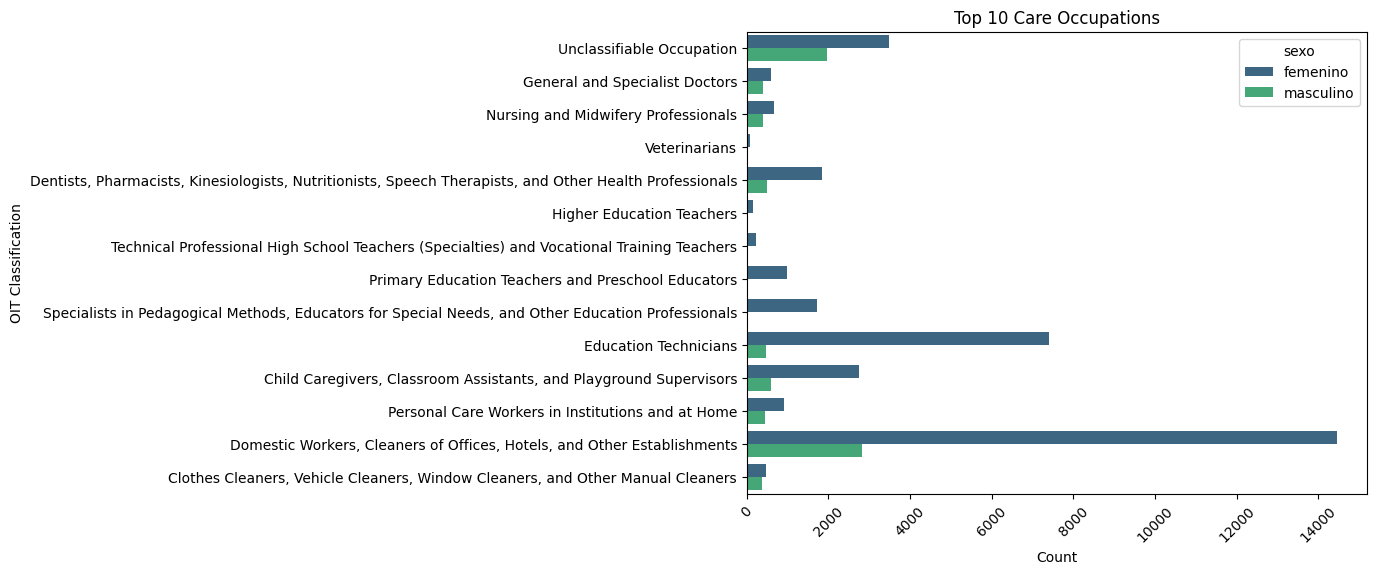

In [96]:
care_duties_df = pd.DataFrame(care_duties, columns=['clasificacion-oit', 'sexo', 'count', 'description'])

plt.figure(figsize=(8, 6))
sns.barplot(y='description', x='count', data=care_duties, palette='viridis', hue='sexo')
plt.xlabel('Count')
plt.ylabel('OIT Classification')
plt.title('Top 10 Care Occupations')
plt.xticks(rotation=45)
plt.show()

In [97]:
# Group by 'clasificacion-oit' and 'sexo' and sum the 'count'
grouped = care_duties_df.groupby(['clasificacion-oit', 'sexo'])['count'].sum().reset_index()
total_counts = grouped.groupby('clasificacion-oit')['count'].sum().reset_index()
sorted_classes = total_counts.sort_values('count', ascending=False)['clasificacion-oit']
grouped['clasificacion-oit'] = pd.Categorical(grouped['clasificacion-oit'],
                                             categories=sorted_classes,
                                             ordered=True)

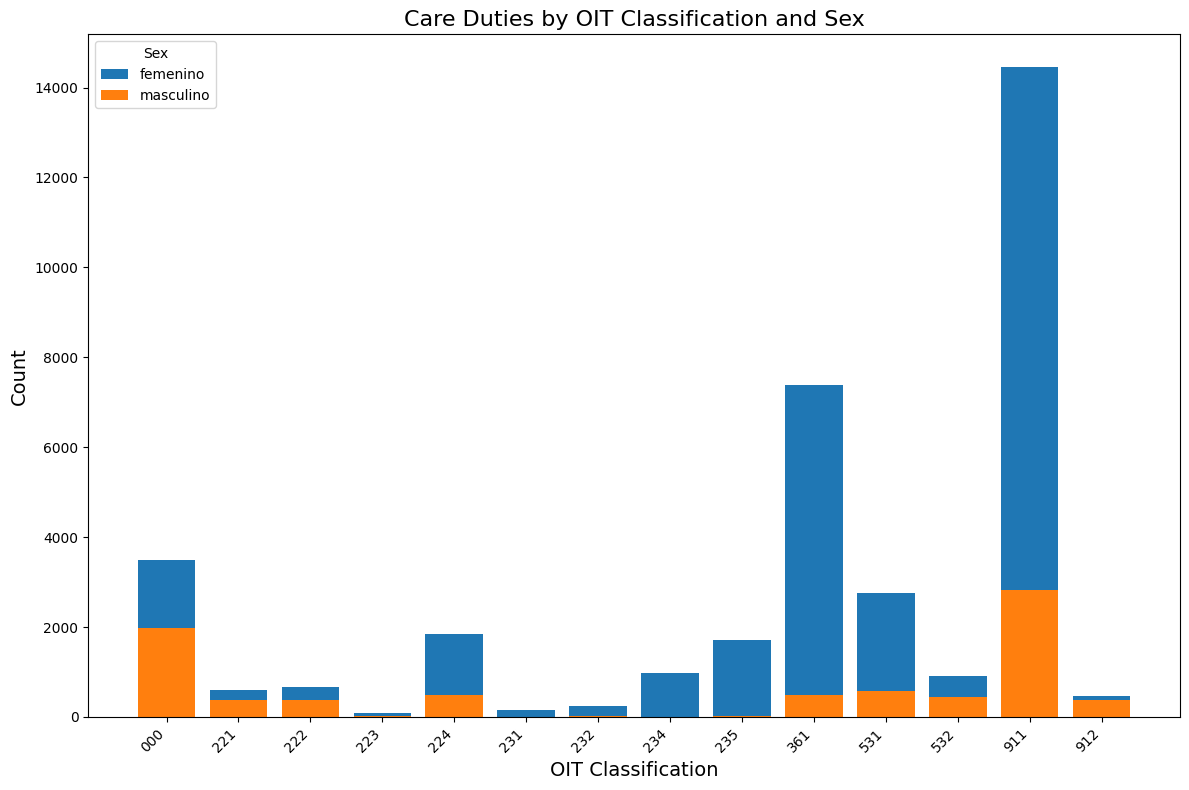

In [98]:
plt.figure(figsize=(12, 8))

for sex in grouped['sexo'].unique():
    subset = grouped[grouped['sexo'] == sex]
    plt.bar(subset['clasificacion-oit'], subset['count'], label=sex)

plt.xlabel('OIT Classification', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Care Duties by OIT Classification and Sex', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sex')
plt.tight_layout()

plt.show()

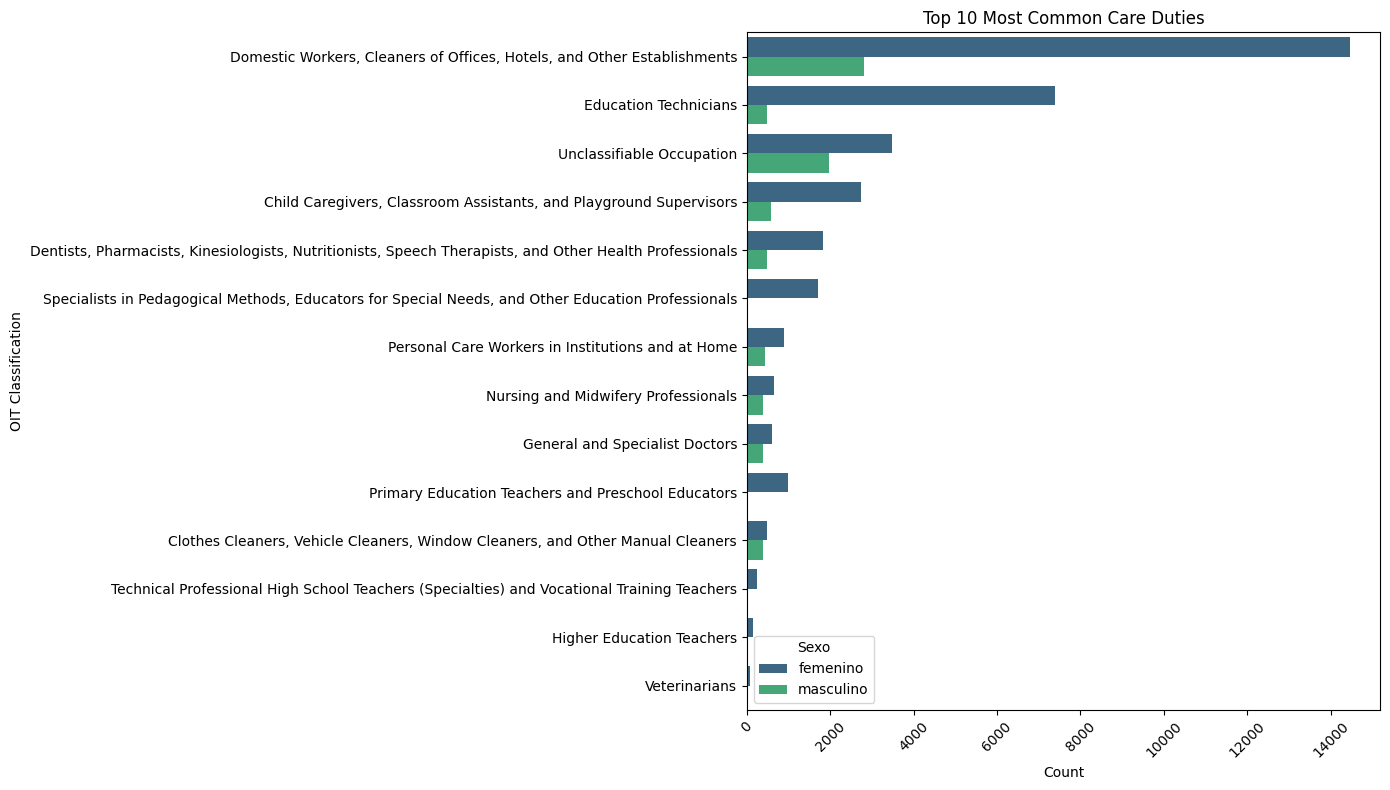

In [99]:
grouped = care_duties_df.groupby(['clasificacion-oit', 'sexo', 'description'])['count'].sum().reset_index()
total_counts = grouped.groupby('description')['count'].sum().sort_values(ascending=False)
sorted_classes = total_counts.index.tolist()

plt.figure(figsize=(14, 8))
sns.barplot(data=grouped,
            y='description',
            x='count',
            hue='sexo',
            order=sorted_classes,
            palette='viridis')

plt.xlabel('Count')
plt.ylabel('OIT Classification')
plt.title('Top 10 Most Common Care Duties')
plt.xticks(rotation=45)
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

/var/folders/zl/7ryjj1xs2ds211qk4d7_6clc0000gn/T/ipykernel_95122/3483489792.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_grouped['description'] = pd.Categorical(top_grouped['description'],


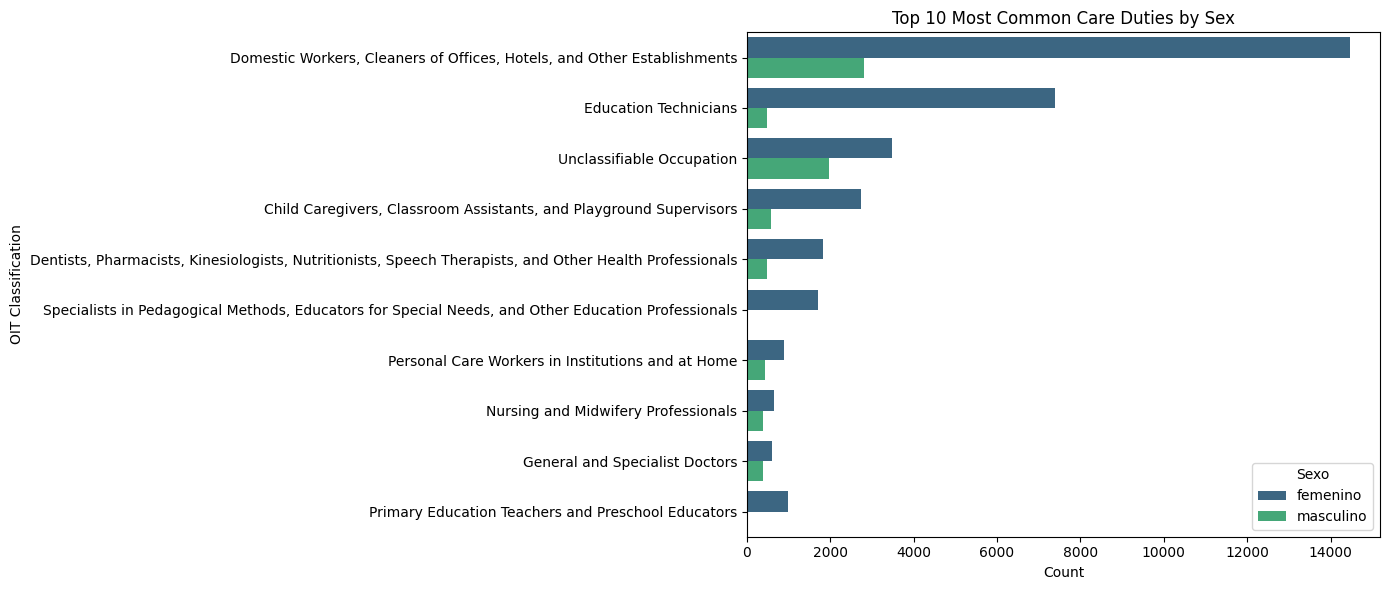

In [100]:
grouped = care_duties_df.groupby(['clasificacion-oit', 'sexo', 'description'])['count'].sum().reset_index()
description_totals = grouped.groupby('description')['count'].sum().sort_values(ascending=False)
top_10_descriptions = description_totals.head(10).index.tolist()

top_grouped = grouped[grouped['description'].isin(top_10_descriptions)]

sorted_descriptions = description_totals.head(10).index.tolist() 
top_grouped['description'] = pd.Categorical(top_grouped['description'],
                                           categories=sorted_descriptions,
                                           ordered=True)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_grouped,
            y='description',
            x='count',
            hue='sexo',
            order=sorted_descriptions,
            palette='viridis')

plt.xlabel('Count')
plt.ylabel('OIT Classification')
plt.title('Top 10 Most Common Care Duties by Sex')
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

# Analysis over Manual Labour and Machinery Based Occupations

In [101]:
industry_occupations_codes = ["83", "72", "92", "81"]
industry_occupations_subcodes = [
    "931", "932", "933", "831", "832",
    "833", "834", "835", "721", "722",
    "723", "921", "811", "812", "813",
    "814", "815", "816", "817", "818",
    "000"
]

In [102]:
industry_occupations = merged_occupations[
    (merged_occupations['clasificacion-oit'].isin(industry_occupations_codes))
]['ocupacion'].unique()

print(len(industry_occupations))

6916


In [103]:
INDUSTRY_SUBGROUPS_CSV_PATH = path.join(DATA_ROOT_PATH, 'classification', 'industry_occupations_subgroups.csv')

In [104]:
care_duties_subgroups_with_description = pd.read_csv(INDUSTRY_SUBGROUPS_CSV_PATH, sep=';')

In [105]:
industry_occupations_classifications = """
You will receive some occupation titles from the user and a table for the International Labour
Organization (ILO) occupational classification system. Your task is to classify the occupations
into one of the ILO's classes. It is important that you reply only with the class number.
Provide the most probable class. If the occupation does not fit any of the provided
classifications, answer with '000'.
"""

In [26]:
classification_industry_occupations_prompt = build_categorization_prompt(
    care_duties_subgroups_with_description
)

print(classification_industry_occupations_prompt)

code;description
931;Obreros de la minería y la construcción
932;Empacadores manuales y obreros de la industria manufacturera
933;Obreros del transporte y almacenamiento
831;Maquinistas de locomotoras, guardafrenos y agentes de maniobras
832;Conductores de motocicletas, automóviles y camionetas
833;Conductores de buses, trolebuses y camiones pesados
834;Operadores de maquinaria agrícola, forestal, máquinas de movimiento de tierras, grúas y montacargas
835;Tripulantes de cubierta de barco
721;Moldeadores, soldadores, chapistas, caldereros, montadores de estructuras metálicas, aparejadores y empalmadores de cables no eléctricos
722;Herreros y herramentistas reguladores y operarios de máquinas herramientas pulidores de metales y afiladores de herramientas
723;Mecánicos de vehículos, motores de aviones, reparadores de máquinas agrícolas, industriales y bicicletas
921;Obreros agropecuarios, de jardinería y horticultura, forestales y pesqueros
811;Mineros y operadores de instalaciones minera

In [106]:
industry_occupations_output_path = path.join(DATA_ROOT_PATH, 'outputs', 'llm_classification_industry_occupations.csv')

In [ ]:
run_classification(
    industry_occupations_output_path,
    industry_occupations,
    industry_occupations_classifications,
    classification_industry_occupations_prompt
)

In [109]:
classified_industry_occupations = pd.read_csv(
    industry_occupations_output_path,
    names=['index', 'ocupacion', 'clasificacion-oit'],
    on_bad_lines='skip',
    dtype={'index': int, 'ocupacion': str, 'clasificacion-oit': str}
)

print(classified_industry_occupations.head())

   index            ocupacion clasificacion-oit
0      0             mecanico               723
1      1  trabajador agricola               921
2      2      operador de cnc               722
3      3      segundo maquina               834
4      4               jornal               000


In [110]:
merged_industry_occupations = pd.merge(new_achs_accidents_data, classified_industry_occupations, on='ocupacion', how='inner')

# We trim the classified with 000 and non 3-digit codes
merged_industry_occupations = merged_industry_occupations[merged_industry_occupations['clasificacion-oit'] != 0]
merged_industry_occupations = merged_industry_occupations[merged_industry_occupations['clasificacion-oit'].isin(industry_occupations_subcodes)]

print(merged_industry_occupations.head())

   id_siniestro  tipo_siniestro  numero_paciente  \
0       7242333               1       1003302110   
1       7245608               1       1007057173   
2       7248030               1       1007058807   
3       7250831               1       1003540761   
4       7255151               1       1006808806   

                                               texto     poblacion  \
0                                            ingreso    TALCAHUANO   
1  Am : No \nMed : no\nAlergias : no \n\nCosechad...   LOS ANGELES   
2  \nCELECOXIB 200 MG (A), ORAL, 200 MG, C/24HRS ...  MONTE PATRIA   
3   \n10.01.2022 16:43 RX TOBILLO AP-LAT-OBL\n\n\n\n    LA PINTANA   
4  \n17.01.2022 18:08 RX DEDO MEDIO AP-LAT-OBL\n1...      PLACILLA   

             ocupacion  edad       sexo  \
0             mecanico  42.0  masculino   
1            temporera  25.0   femenino   
2  trabajador agricola  24.0  masculino   
3      operador de cnc  38.0  masculino   
4      segundo maquina  36.0  masculino   

       

In [111]:
# Group by classification and sex
classification_counts_industry = merged_industry_occupations.groupby(['clasificacion-oit', 'sexo']).size().reset_index(name='count')

print(classification_counts_industry)

   clasificacion-oit       sexo  count
0                000   femenino   2087
1                000  masculino  12406
2                721   femenino     33
3                721  masculino   5820
4                722   femenino      5
5                722  masculino    789
6                723   femenino     47
7                723  masculino   5804
8                811   femenino      1
9                811  masculino    189
10               812   femenino      1
11               812  masculino    184
12               813   femenino     18
13               813  masculino    170
14               814   femenino     52
15               814  masculino    147
16               815  masculino     27
17               816   femenino      2
18               816  masculino     87
19               817  masculino     66
20               818   femenino     10
21               818  masculino    463
22               831   femenino    157
23               831  masculino    414
24               832   fe

In [112]:
TRANSLATED_INDUSTRY_OCCUPATIONS_SUBGROUPS_PATH = path.join(
    DATA_ROOT_PATH, 'classification', 'translated_industry_occupations_subgroups.csv'
)

classification_codes_description = pd.read_csv(
    TRANSLATED_CARE_DUTIES_SUBGROUPS_PATH,
    sep=';',
    names=['code', 'description'],
    on_bad_lines='skip',
    dtype={'code': str, 'description': str}
)

# Standarization for formats
classification_counts_industry['clasificacion-oit'] = classification_counts_industry['clasificacion-oit'].astype(str)

print(classification_codes_description.head())

   code                          description
0  code                          description
1   221       General and Specialist Doctors
2   222  Nursing and Midwifery Professionals
3   223                        Veterinarians
4   231            Higher Education Teachers


In [113]:
industry_occupations = pd.merge(
    classification_counts,
    classification_codes_description,
    left_on='clasificacion-oit',
    right_on='code',
    how='left'
)

print(industry_occupations.head())

  clasificacion-oit       sexo  count code  \
0               000   femenino   3481  000   
1               000  masculino   1971  000   
2               221   femenino    600  221   
3               221  masculino    389  221   
4               222   femenino    660  222   

                           description  
0            Unclassifiable Occupation  
1            Unclassifiable Occupation  
2       General and Specialist Doctors  
3       General and Specialist Doctors  
4  Nursing and Midwifery Professionals  


In [115]:
import textwrap

total_counts = industry_occupations.groupby('description')['count'].sum().reset_index()
top_10_descriptions = total_counts.nlargest(10, 'count')['description']

top_10_data = industry_occupations[industry_occupations['description'].isin(top_10_descriptions)]

gender_mapping = {'masculino': 'Male', 'femenino': 'Female'}
top_10_data['gender'] = top_10_data['sexo'].map(gender_mapping)

top_10_data['wrapped_description'] = top_10_data['description'].apply(
    lambda x: '\n'.join(textwrap.wrap(x, width=63))
)

gender_mapping = {'masculino': 'Male', 'femenino': 'Female'}
top_10_data['gender'] = top_10_data['sexo'].map(gender_mapping)


/var/folders/zl/7ryjj1xs2ds211qk4d7_6clc0000gn/T/ipykernel_95122/4222420981.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_data['gender'] = top_10_data['sexo'].map(gender_mapping)
/var/folders/zl/7ryjj1xs2ds211qk4d7_6clc0000gn/T/ipykernel_95122/4222420981.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_data['wrapped_description'] = top_10_data['description'].apply(
/var/folders/zl/7ryjj1xs2ds211qk4d7_6clc0000gn/T/ipykernel_95122/4222420981.py:16: SettingWithCopyWarning: 
A value is t

/var/folders/zl/7ryjj1xs2ds211qk4d7_6clc0000gn/T/ipykernel_95122/2183753435.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


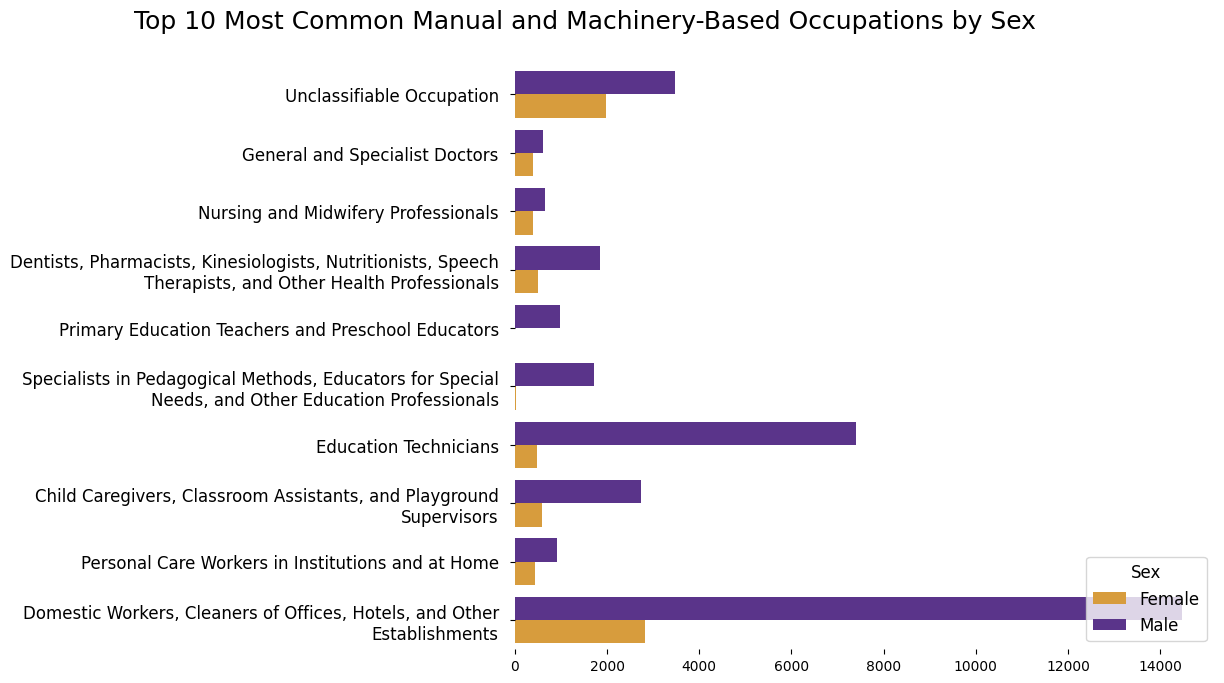

In [117]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    y='wrapped_description',
    x='count',
    data=top_10_data,
    hue='gender',
    palette={'Male': '#D79C3D', 'Female': '#5A348A'},
    alpha=1.0
)

# Manually set patch colors
for i, patch in enumerate(ax.patches):
    if i < 10 or i == 20:
        patch.set_facecolor('#5A348A')  # Female
    else:
        patch.set_facecolor('#D79C3D')  # Male

# Labels
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)

# Centered title at figure level
plt.suptitle(
    'Top 10 Most Common Manual and Machinery-Based Occupations by Sex',
    fontsize=18,
    y=0.95  # Space above the graph
)

# Improve y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.tick_params(axis='y', pad=8)  # Space between categories

# Legend
plt.legend(
    title='Sex',
    loc='lower right',
    bbox_to_anchor=(1, 0),
    frameon=True,
    fontsize=12,
    title_fontsize=12
)

# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Adjust margins
plt.subplots_adjust(left=0.45, right=0.95, top=0.88, bottom=0.15)


In [134]:
MECHANISMS_DICC_PATH = path.join(DATA_ROOT_PATH, 'masked', 'dicc_mecanismo_new_refined2.2.csv')

In [135]:
df_dicc = pd.read_csv(MECHANISMS_DICC_PATH, sep=';')
df_dicc = df_dicc.rename(columns={"Codigo SUSESO 2018": "mecanismo"})

print(df_dicc.columns)
print(df_dicc.head())

Index(['desc_subforma', 'mecanismo', 'DETALLE MECANISMO LESIONAL'], dtype='object')
  desc_subforma  mecanismo                         DETALLE MECANISMO LESIONAL
0        CAIDAS       11.1  Caida a distinto nivel - Desde alturas >= 1.8 ...
1        CAIDAS       11.2  Caida a distinto nivel - Desde alturas < 1.8 m...
2        CAIDAS       11.3               Caida a distinto nivel - Profundidad
3        CAIDAS       12.1                            Caidas a un mismo nivel
4        GOLPES       21.1  Golpeado por objetos de Derrumbe (Ej.Caidas de...


In [136]:
df_mechanisms_industry_occupations = pd.merge(merged_industry_occupations, df_dicc, on= 'mecanismo')

print(df_mechanisms_industry_occupations.head())

   id_siniestro  tipo_siniestro  numero_paciente  \
0       7242333               1       1003302110   
1       7245608               1       1007057173   
2       7248030               1       1007058807   
3       7250831               1       1003540761   
4       7255151               1       1006808806   

                                               texto     poblacion  \
0                                            ingreso    TALCAHUANO   
1  Am : No \nMed : no\nAlergias : no \n\nCosechad...   LOS ANGELES   
2  \nCELECOXIB 200 MG (A), ORAL, 200 MG, C/24HRS ...  MONTE PATRIA   
3   \n10.01.2022 16:43 RX TOBILLO AP-LAT-OBL\n\n\n\n    LA PINTANA   
4  \n17.01.2022 18:08 RX DEDO MEDIO AP-LAT-OBL\n1...      PLACILLA   

             ocupacion  edad       sexo  \
0             mecanico  42.0  masculino   
1            temporera  25.0   femenino   
2  trabajador agricola  24.0  masculino   
3      operador de cnc  38.0  masculino   
4      segundo maquina  36.0  masculino   

       

In [137]:
grouped = df_mechanisms_industry_occupations.groupby(
    ['desc_subforma', 'sexo']
).size().reset_index(name='count')

print(grouped.head())

                         desc_subforma       sexo  count
0  ACCIDENTES QUE INVOLUCRAN VEHICULOS   femenino    465
1  ACCIDENTES QUE INVOLUCRAN VEHICULOS  masculino   7226
2               AGRESIONES DE ANIMALES   femenino     23
3               AGRESIONES DE ANIMALES  masculino    333
4     AMENZAS O AGRESIONES DE PERSONAS   femenino    105


In [138]:
TRANSLATED_MECHANISMS_PATH = path.join(DATA_ROOT_PATH, 'classification', 'translated_mechanisms.csv')

In [139]:
mechanisms_descriptions = pd.read_csv(TRANSLATED_MECHANISMS_PATH, sep=';')

In [140]:
description_totals = grouped.groupby('desc_subforma')['count'].sum().sort_values(ascending=False)

top_10_descriptions = description_totals.head(11).index.tolist()
top_grouped = grouped[grouped['desc_subforma'].isin(top_10_descriptions)]


top_grouped = pd.merge(top_grouped, mechanisms_descriptions, left_on='desc_subforma', right_on='español', how='left')

categories_order = top_grouped.groupby("desc_subforma").sum()["count"].sort_values(ascending = False).reset_index()["desc_subforma"].to_list()
top_grouped["desc_subforma"] = pd.Categorical(top_grouped["desc_subforma"], categories = categories_order, ordered = True)
top_grouped = top_grouped.sort_values("desc_subforma").reset_index()

<Axes: xlabel='count', ylabel='traduccion'>

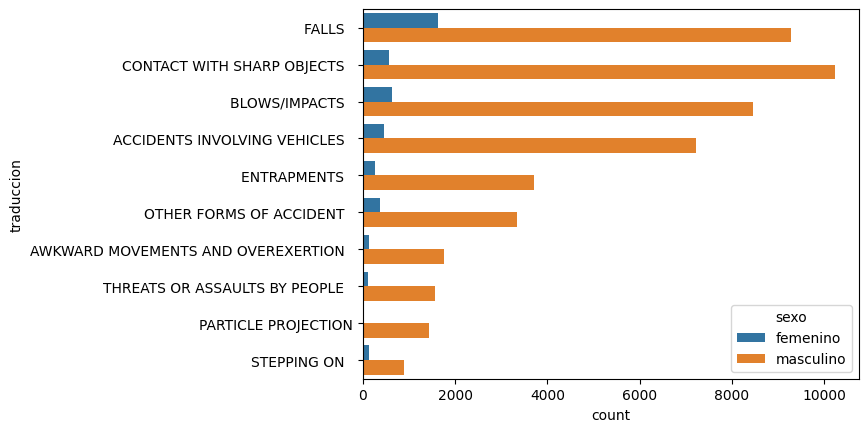

In [ ]:
sns.barplot(data = top_grouped, x = "count", y = "traduccion", hue = "sexo", hue_order=['femenino', 'masculino'])

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

top_grouped['wrapped_description'] = top_grouped['desc_subforma'].apply(
    lambda x: '\n'.join(textwrap.wrap(x, width=63))
)

top_grouped['traduccion'] = top_grouped['traduccion'].str.capitalize()
gender_mapping = {'femenino': 'Female', 'masculino': 'Male'}
top_grouped['gender'] = top_grouped['sexo'].map(gender_mapping)

22


/var/folders/zl/7ryjj1xs2ds211qk4d7_6clc0000gn/T/ipykernel_95122/3050874469.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


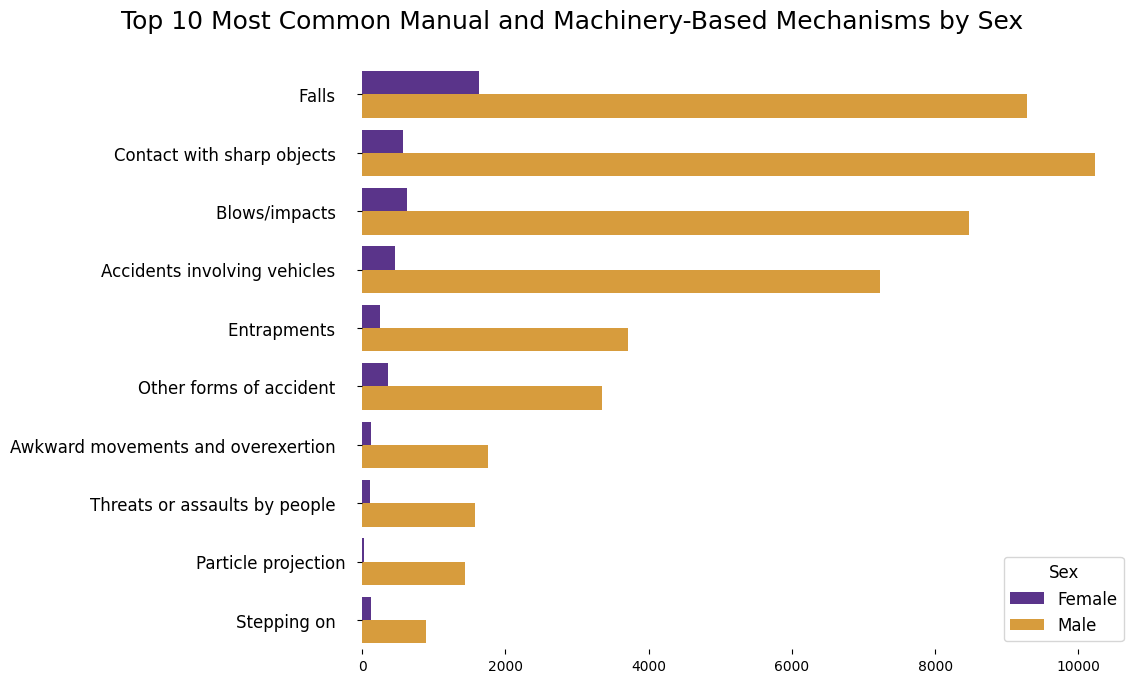

In [147]:

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=top_grouped,
    x="count",
    y="traduccion",
    hue="gender",
    hue_order=['Female', 'Male'],
    palette={'Male': '#D79C3D', 'Female': '#5A348A'},
    alpha=1.0
)

print(len(ax.patches))


for i, patch in enumerate(ax.patches):
    if i < 10 or i == 20:
        patch.set_facecolor('#5A348A')  # Female
    else:
        patch.set_facecolor('#D79C3D')  # Male


plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)

plt.suptitle(
    'Top 10 Most Common Manual and Machinery-Based Mechanisms by Sex',
    fontsize=18,
    y=0.95,
    x=0.55
)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.tick_params(axis='y', pad=8)

plt.legend(
    title='Sex',
    loc='lower right',
    bbox_to_anchor=(1, 0),
    frameon=True,
    fontsize=12,
    title_fontsize=12
)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.subplots_adjust(left=0.40, right=0.95, top=0.88, bottom=0.15)

### Care Duties and Mechanisms Analysis

In [148]:
df_mechanisms_care_duties = pd.merge(merged_care_duties, df_dicc, on= 'mecanismo')

print(df_mechanisms_care_duties.head())

   id_siniestro  tipo_siniestro  numero_paciente  \
0       7246825               1       1001236538   
1       7252561               2       1007061785   
2       7252843               1       1007062205   
3       7261280               1       1007068429   
4       7265217               1       1007070918   

                                               texto   poblacion  \
0  BEG CLOTE OBESIDAD CENTRAL \n\nINGRESA EN SILL...    PUDAHUEL   
1                      REGULARIZACION  DE TRANSPORTE  SAN FELIPE   
2  \nALTA MEDICA\nCICLOBENZAPRINA 10 MG UN COMP. ...       AISEN   
3        ME GOLPEARON UN  MARTILLAZO EN EL ANTEBRAZO     QUILPUE   
4                                 control con imagen  LAS CONDES   

                 ocupacion  edad      sexo  \
0              aux de aseo  56.0  femenino   
1         auxiliar de aseo  48.0  femenino   
2              kinesiologa  28.0  femenino   
3  educadora trato directo  33.0  femenino   
4          auxiiar de aseo  60.0  femenino   

 

In [149]:
grouped = df_mechanisms_care_duties.groupby(['desc_subforma', 'sexo']).size().reset_index(name='count')

print(grouped.head())

                         desc_subforma       sexo  count
0  ACCIDENTES QUE INVOLUCRAN VEHICULOS   femenino   3178
1  ACCIDENTES QUE INVOLUCRAN VEHICULOS  masculino    894
2               AGRESIONES DE ANIMALES   femenino    234
3               AGRESIONES DE ANIMALES  masculino     83
4     AMENZAS O AGRESIONES DE PERSONAS   femenino   2544


<Axes: xlabel='count', ylabel='traduccion'>

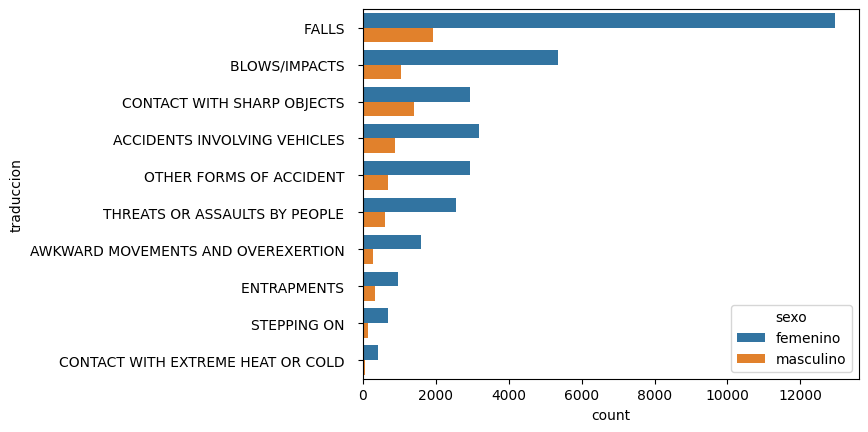

In [154]:
description_totals = grouped.groupby('desc_subforma')['count'].sum().sort_values(ascending=False)
top_10_descriptions = description_totals.head(11).index.tolist()
top_grouped = grouped[grouped['desc_subforma'].isin(top_10_descriptions)]

top_grouped = pd.merge(top_grouped, mechanisms_descriptions, left_on='desc_subforma', right_on='español', how='left')

categories_order = top_grouped.groupby("desc_subforma").sum()["count"].sort_values(ascending = False).reset_index()["desc_subforma"].to_list()
top_grouped["desc_subforma"] = pd.Categorical(top_grouped["desc_subforma"], categories = categories_order, ordered = True)
top_grouped = top_grouped.sort_values("desc_subforma").reset_index()


sns.barplot(data = top_grouped, x = "count", y = "traduccion", hue = "sexo", hue_order=['femenino', 'masculino'])

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

gender_mapping = {'femenino': 'Female', 'masculino': 'Male'}
top_grouped['gender'] = top_grouped['sexo'].map(gender_mapping)

top_grouped['traduccion'] = top_grouped['traduccion'].str.capitalize()

/var/folders/zl/7ryjj1xs2ds211qk4d7_6clc0000gn/T/ipykernel_95122/3139949653.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


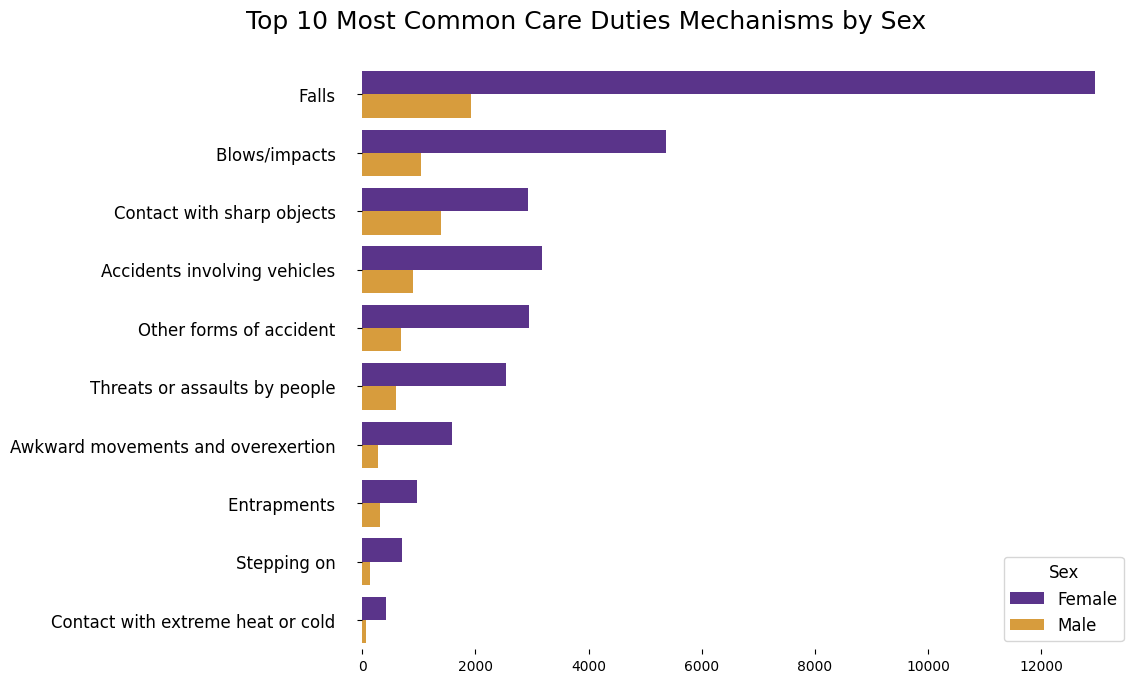

In [153]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=top_grouped,
    x="count",
    y="traduccion",
    hue="gender",
    hue_order=['Female', 'Male'],
    palette={'Male': '#D79C3D', 'Female': '#5A348A'},
    alpha=1.0
)

for i, patch in enumerate(ax.patches):
    if i < 10 or i == 20:
        patch.set_facecolor('#5A348A')  # Female
    else:
        patch.set_facecolor('#D79C3D')  # Male

plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)

plt.suptitle(
    'Top 10 Most Common Care Duties Mechanisms by Sex',
    fontsize=18,
    y=0.95,
    x=0.56
)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.tick_params(axis='y', pad=8)

plt.legend(
    title='Sex',
    loc='lower right',
    bbox_to_anchor=(1, 0),
    frameon=True,
    fontsize=12,
    title_fontsize=12
)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.subplots_adjust(left=0.40, right=0.95, top=0.88, bottom=0.15)